In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def data_segmentation(df, y_label, window_size = 100, stride = 50):
    '''
    Segments the data into the same length and detach the whole dataset into X and y.
    
    df: data frame that contains all covariates and response variables
    y_label: the column name of the response variable that we want to predict
    window_size: the length of time included in a single data point
    stride: The interval between two closest segmented data point
    '''
    j = df.columns.get_loc(y_label)
    data = df.to_numpy()
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    
    while start <= n - window_size:
        end = start + window_size - 1
        if data[start][j] == data[end][j] and data[start][0] + 0.01 > data[end][0] and data[start][j]!=0:
            X.append(data[start:(end+1),1:-7])
            y.append(data[start][j])
            start += stride
        else:
            while start + window_size - 1 < n:
                if data[start][j] != data[start+1][j]:
                    break
                start += 1
            start += 1
    return np.asarray(X), np.asarray(y)

In [4]:
def flatten_features(X_3d):
    """
    Converts the 3D (n_samples, n_timesteps, n_features) tensor 
    into a 2D (n_samples, n_features_flattened) matrix for XGBoost.

    We do this by calculating summary statistics for each feature across all timesteps.
    """
    n_samples, n_timesteps, n_features = X_3d.shape
    print(f"Flattening 3D data... Input shape: {X_3d.shape}")

    # We will calculate the slope for each feature, which requires a time vector
    # This is our 'x' for the linear regression
    timesteps_x = np.arange(n_timesteps).reshape(-1, 1)

    # Initialize a list to hold the feature vectors for all samples
    all_subject_features = []

    # Use tqdm for a progress bar, as this can be slow
    for i in range(n_samples):
        subject_data = X_3d[i, :, :]  # Shape (n_timesteps, n_features)
        
        # 1. Calculate basic statistics across time (axis=0)
        mean_features = np.mean(subject_data, axis=0)  # Shape (n_features,)
        std_features = np.std(subject_data, axis=0)    # Shape (n_features,)
        max_features = np.max(subject_data, axis=0)    # Shape (n_features,)
        min_features = np.min(subject_data, axis=0)    # Shape (n_features,)
        
        # 2. Get the last known value for each feature
        last_features = subject_data[-1, :]            # Shape (n_features,)


        # 4. Concatenate all our new features into a single 1D vector
        # We have 6 sets of stats, each with n_features
        subject_feature_vector = np.concatenate([
            mean_features,
            std_features,
            max_features,
            min_features,
            last_features,
        ])
        
        all_subject_features.append(subject_feature_vector)

    # Convert the list of vectors into our new 2D matrix
    X_flattened = np.array(all_subject_features)
    print(f"Flattening complete. New X shape: {X_flattened.shape}")
    return X_flattened

In [5]:
df_S1 = pd.read_csv("S1.csv")
df_S2 = pd.read_csv("S2.csv")
df_S3 = pd.read_csv("S3.csv")
df_S4 = pd.read_csv("S4.csv")

In [17]:
X1_test, y1_test = data_segmentation(df_S1, "Locomotion")
X2_test, y2_test = data_segmentation(df_S2, "Locomotion")
X3_test, y3_test = data_segmentation(df_S3, "Locomotion")
X4_test, y4_test = data_segmentation(df_S4, "Locomotion")
y1_test[y1_test == 5] = 3
y2_test[y2_test == 5] = 3
y3_test[y3_test == 5] = 3
y4_test[y4_test == 5] = 3
y1_test -= 1
y2_test -= 1
y3_test -= 1
y4_test -= 1

In [6]:
X1_test, y1_test = data_segmentation(df_S1, "HL_Activity")
X2_test, y2_test = data_segmentation(df_S2, "HL_Activity")
X3_test, y3_test = data_segmentation(df_S3, "HL_Activity")
X4_test, y4_test = data_segmentation(df_S4, "HL_Activity")
y1_test -= 101
y2_test -= 101
y3_test -= 101
y4_test -= 101

In [9]:
np.concatenate([X1_test, X2_test], axis = 0).shape

(5782, 100, 127)

In [18]:
result = np.zeros((4,4))
X = [X1_test, X2_test, X3_test, X4_test]
y = [y1_test, y2_test, y3_test, y4_test]
for i in range(4):
    X = [X1_test, X2_test, X3_test, X4_test]
    y = [y1_test, y2_test, y3_test, y4_test]
    X_test = X.pop(i)
    y_test = y.pop(i)
    X_train = np.concatenate(X, axis = 0)
    y_train = np.concatenate(y, axis = 0)
    xgb_train = np.concatenate((X_train.mean(axis=1), X_train.std(axis=1), X_train.max(axis=1), X_train.min(axis=1)),axis = 1)
    xgb_test = np.concatenate((X_test.mean(axis=1), X_test.std(axis=1), X_test.max(axis=1), X_test.min(axis=1)),axis = 1)   
    
    num_classes = len(np.unique(y_train))
    model = xgb.XGBClassifier(
            objective='multi:softmax',  # Use 'multi:softmax' for multi-class
            num_class=num_classes,      # Tell XGBoost how many classes to expect
            eval_metric='mlogloss',     # 'mlogloss' is for multi-class
            n_estimators=100,  # Number of trees
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1  # Use all available CPU cores
        )
    xgb_train = np.concatenate((X_train.mean(axis=1), X_train.std(axis=1), X_train.max(axis=1), X_train.min(axis=1)),axis = 1)
    xgb_test = np.concatenate((X_test.mean(axis=1), X_test.std(axis=1), X_test.max(axis=1), X_test.min(axis=1)),axis = 1)
    model.fit(xgb_train, y_train)
    y_pred = model.predict(xgb_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    result[i,0] = accuracy
    result[i,1] = precision
    result[i,2] = recall
    result[i,3] = f1
    print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}")


accuracy: 0.9618082618862042, precision: 0.9617102086937167, recall: 0.9618082618862042, f1: 0.9612974341660045
accuracy: 0.9599173553719008, precision: 0.9613940253037906, recall: 0.9599173553719008, f1: 0.9598986237600041
accuracy: 0.9513734224201931, precision: 0.9537346856766449, recall: 0.9513734224201931, f1: 0.9468157388598784
accuracy: 0.9656338028169014, precision: 0.9664944007387851, recall: 0.9656338028169014, f1: 0.9647148132235468


In [ ]:
np.mean(result, axis = 0)

array([0.74366528, 0.75643275, 0.74366528, 0.73927138])

In [21]:
np.std(result, axis = 0)
from scipy import stats
np.std(result, axis = 0)/np.sqrt(4)*stats.t.ppf(0.975, df=3)

array([0.00830768, 0.00727111, 0.00830768, 0.01080751])

In [19]:
np.mean(result, axis = 0)

array([0.95968321, 0.96083333, 0.95968321, 0.95818165])

In [20]:
np.std(result, axis = 0)

array([0.00522094, 0.00456951, 0.00522094, 0.00679195])

In [27]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


# ROC curve multi-class classification
y_prob = model.predict_proba(xgb_test)
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Print the evaluation metrics
print("Accuracy:", f"{accuracy:.4f}")
print("Precision:", f"{precision:.4f}")
print("Recall:", f"{recall:.4f}")
print("F1 Score:", f"{f1:.4f}")
print("AUC:", f"{macro_roc_auc_ovo:.4f}")

Accuracy: 0.6938
Precision: 0.7173
Recall: 0.6938
F1 Score: 0.6755
AUC: 0.9319


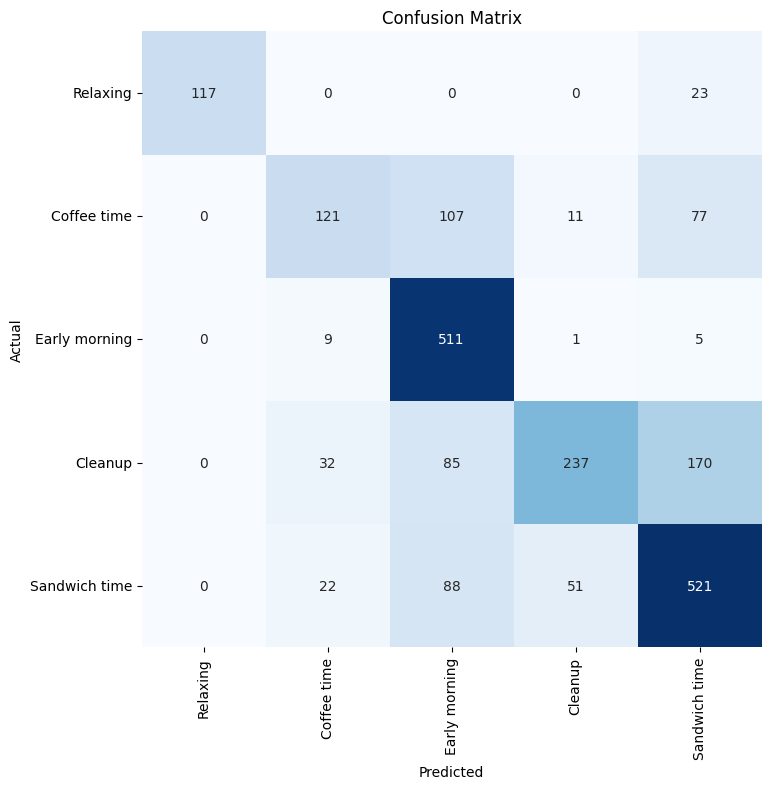

In [23]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
num_classes = len(np.unique(y_train))
model = xgb.XGBClassifier(
        objective='multi:softmax',  # Use 'multi:softmax' for multi-class
        num_class=num_classes,      # Tell XGBoost how many classes to expect
        eval_metric='mlogloss',     # 'mlogloss' is for multi-class
        n_estimators=200,  # Number of trees
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1  # Use all available CPU cores
    )
y_train[y_train == 5] = 3
y_test[y_test == 5] = 3
model.fit(flatten_features(X_train), y_train)
print("Training complete.")


# --- 6. Evaluate the Model ---
print("\n--- Model Evaluation ---")
y_pred = model.predict(flatten_features(X_test))


Flattening 3D data... Input shape: (8239, 100, 124)
Flattening complete. New X shape: (8239, 620)
Training complete.

--- Model Evaluation ---
Flattening 3D data... Input shape: (2188, 100, 124)
Flattening complete. New X shape: (2188, 620)


In [11]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


# ROC curve multi-class classification
y_prob = model.predict_proba(flatten_features(X_test))
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Print the evaluation metrics
print("Accuracy:", f"{accuracy:.4f}")
print("Precision:", f"{precision:.4f}")
print("Recall:", f"{recall:.4f}")
print("F1 Score:", f"{f1:.4f}")
print("AUC:", f"{macro_roc_auc_ovo:.4f}")

Flattening 3D data... Input shape: (2188, 100, 124)
Flattening complete. New X shape: (2188, 620)
Accuracy: 0.6910
Precision: 0.7192
Recall: 0.6910
F1 Score: 0.6711
AUC: 0.9350


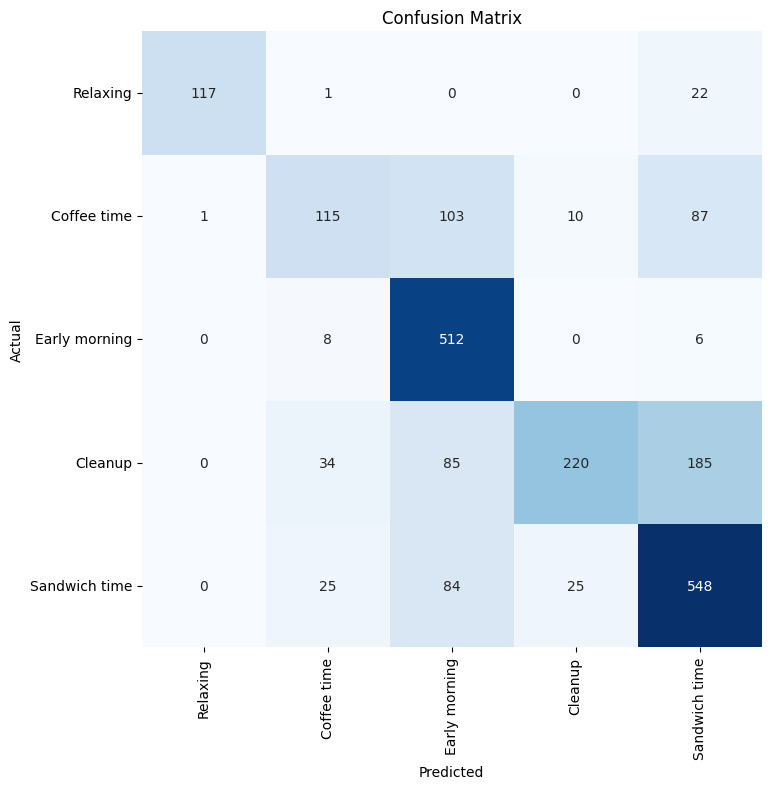

In [12]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier # For classification tasks
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix
# Create the Random Forest model instance
# n_estimators=100 is the default and a good starting point
# We'll set a max_depth to prevent overly complex trees
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1 # Use all available cores for faster training
)

# Train the model on the training data
print("Starting model training...")
rf_model.fit(X_train.mean(axis=1), y_train)
print("Model training complete.")
# Make predictions on the test set
y_pred = rf_model.predict(X_test.mean(axis=1))

# Evaluate the model's performance
print("\n## Model Evaluation Metrics ##")

# Confusion Matrix
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

# Classification Report (Precision, Recall, F1-Score)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Overall accuracy
accuracy = rf_model.score(X_test.mean(axis=1), y_test)
print(f"\nOverall Test Accuracy: {accuracy:.4f}")

Starting model training...
Model training complete.

## Model Evaluation Metrics ##

--- Confusion Matrix ---
[[103   2   3   0  32]
 [  0 121  95   9  91]
 [  0  20 490   0  16]
 [  0  54 190  72 208]
 [  0  20  97  19 546]]

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       1.00      0.74      0.85       140
         1.0       0.56      0.38      0.45       316
         2.0       0.56      0.93      0.70       526
         3.0       0.72      0.14      0.23       524
         4.0       0.61      0.80      0.69       682

    accuracy                           0.61      2188
   macro avg       0.69      0.60      0.59      2188
weighted avg       0.64      0.61      0.56      2188


Overall Test Accuracy: 0.6088
